# DTDstd: Debris Thermal Diffusivity sampling time dependency

### Info on this notebook:
In this jupyter notebook you can investigate the sampling interval dependency of debris thermal diffusivity calculations. 

#### Python Librarys required:

* NumPy (v1.20.0)
* Matplotlib (v3.4.1)
* Statsmodels (v0.12.2)
* Pandas (v1.2.4)
* DateTime (v4.3)
* SciPy (v1.6.2)
* TQDM (v4.59.0)
* Natsort (v7.1.1)

Program code was tested with the stated library versions, but should also work flawlessly with every other recent version.

## Python program:

### Load libraries:

In [1]:
import numpy as np
from tqdm import tqdm
import natsort
import math

import plotfunction
import functions
import analysis

### Select (your) dataset:

You can either add your own URL with data or just select between the three datasets:

* Ngozumpa (2001-2002) http://doi.org/10.5281/zenodo.3935687
* Artificial data: Pure sine forcing for 100cm thick debris layer
* Artificial data: Example daily cycle forcing for 100cm thick debris layer 

When using your own data it must have the following header format (T_air not required):

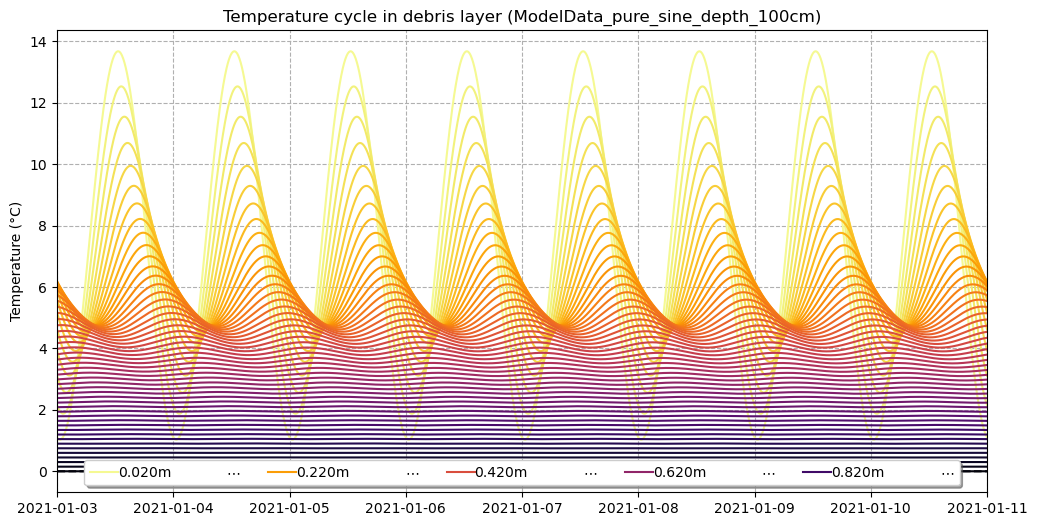

In [2]:
directory = 'saved_model_data/' # replace with file directory
file_name_list = ['ModelData_pure_sine_depth_100cm.csv'] # replace with file name

file_name = file_name_list[0] # index the datasets above with an integer from 0 to 2.

T_error = 0.2  # What is your thermistor temperature uncertainty?
delta_error = False # Add vertical position error of temperature measurement [True/False]
delta_x_error = 0.005  # Select standard deviation of gaussian distribution [0.0, 0.0025, 0.005, 0075, 0.001]
save_figure = True  # Do you want to save THIS figures as .pdf?
vertical_resampling = False # Do you want to spatially resample the data?
vertical_resampling_factor = 1 # ente 1 for every measurement height, 2 for every second and so on

"""Dont change anything here"""
path = directory + file_name
df_main, index_list = functions.read_csv_file(path)
if vertical_resampling == True:
    df_main = df_main[df_main.columns[::vertical_resampling_factor]]
site = file_name[:-4]
depth = list(df_main.columns)
dates_list = functions.dates(df_main)
plotfunction.temperature_timeseries(dates_list, df_main, depth, site, save_figure)

### Select if you want to analyze all data or just a defined period

In [3]:
sel_period = False # to select a period set value to True, otherwise input False
from_date = '2001-12-15' # format: YYYY-MM-DD
to_date = '2002-01-05'

df_sel, index_list = functions.select_time_period(df_main, index_list, sel_period, from_date, to_date)
if sel_period:
    plotfunction.temperature_timeseries(index_list, df_sel, depth, site, save_figure, from_date, to_date)

First day neglected due to incomplete daily data.
Last day neglected due to incomplete daily data.


### Select if you want to resample your data by averaging or skipping

In [4]:
sel_average = False # set to True for averaging and False for skipping.

### What should the maximum sampling interval / averaging time be?

In [5]:
max_minutes = 360 # maximum sampling / averaging time in minutes

### Setup data for analysis

In [6]:
if df_sel.empty:  # WARNINGS
    print('No data in', site, 'for selected period.')
if len(df_sel.columns) <= 2:
    print('Measurements with a minimum of 3 different depths required.')

depth = list(df_sel.columns)  # list of column names
if depth != natsort.natsorted(depth):
    if not all(len(l) == len(depth[0]) for l in depth):
        print('No automatic sorting possible. Check if order is correct:')
        print(depth)
    else:
        depth = natsort.natsorted(depth)
        print('Wrong column order: Depth columns sorted to correct order:')
        print(depth)
depth_vec = functions.depth_from_string(depth)  # depth from surface

duplicates = functions.list_duplicates(depth_vec)
if len(duplicates) >= 1:
    for dup in duplicates:
        string1 = 'T_' + str(dup) + 'm'
        string2 = 'T_' + str(dup) + 'm.1'
        df_sel[string1] = df_sel[[string1, string2]].mean(axis=1)
        df_sel = df_sel.drop(columns=[string2])
        print('Duplicate columns averaged.')
    depth = list(df_sel.columns)
    depth_vec = functions.depth_from_string(depth)

In [7]:
if delta_error == True:
    rng = np.random.default_rng()
    weights = rng.normal(0, delta_x_error, size=len(depth_vec))
    for d in range(len(depth_vec)):
        depth_vec[d] = depth_vec[d] - weights[d]

In [8]:
levels = len(depth) - 2  # number of calculated height levels

dates_list = functions.dates(df_sel)
Delta_t, steps, steps_list = functions.sampling_interval(index_list,
                                                         max_minutes)

data = np.empty((levels, len(dates_list), len(steps)))
data[:] = np.nan
r_squared = data.copy()
data_period = np.empty((levels, len(steps)))
data_period[:] = np.nan
r_squared_period = data_period.copy()

## Effects of temporal sampling and averaging interval on  thermal diffusivity:

### Loop over sampling intervals / averaging times

  0%|                                                    | 0/72 [00:00<?, ?it/s]

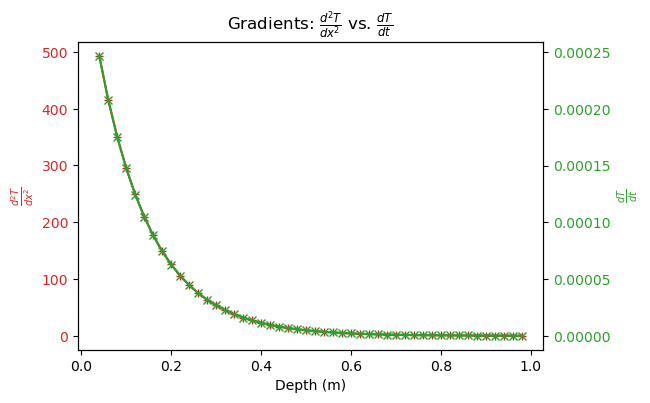

/home/calvin/anaconda3/envs/calvin/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/calvin/anaconda3/envs/calvin/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/calvin/anaconda3/envs/calvin/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, 

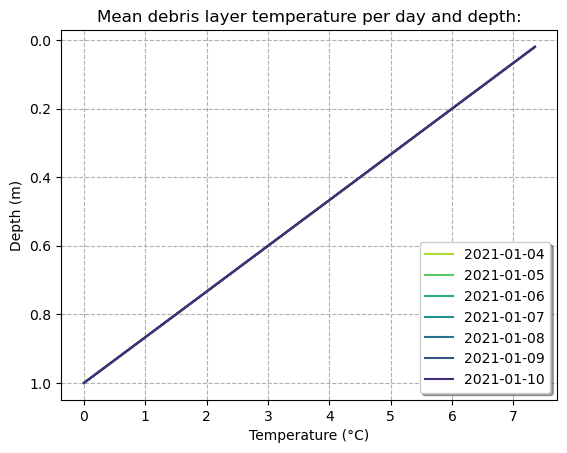

100%|███████████████████████████████████████████| 72/72 [00:54<00:00,  1.32it/s]


In [9]:
for step in tqdm((steps), position=0, leave=True):
    data, r_squared, data_period, r_squared_period = analysis.run(df_sel, step, steps, data, r_squared, data_period,
             r_squared_period, depth, depth_vec, levels, dates_list, 
             Delta_t, site, sel_average, save_figure)

In [10]:
print('Select value between 0 and ' + str(len(steps_list)-1) + ' for the corresponding averaging / sampling time:')
print(steps_list)

Select value between 0 and 71 for the corresponding averaging / sampling time:
[  5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90
  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180
 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270
 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355 360]


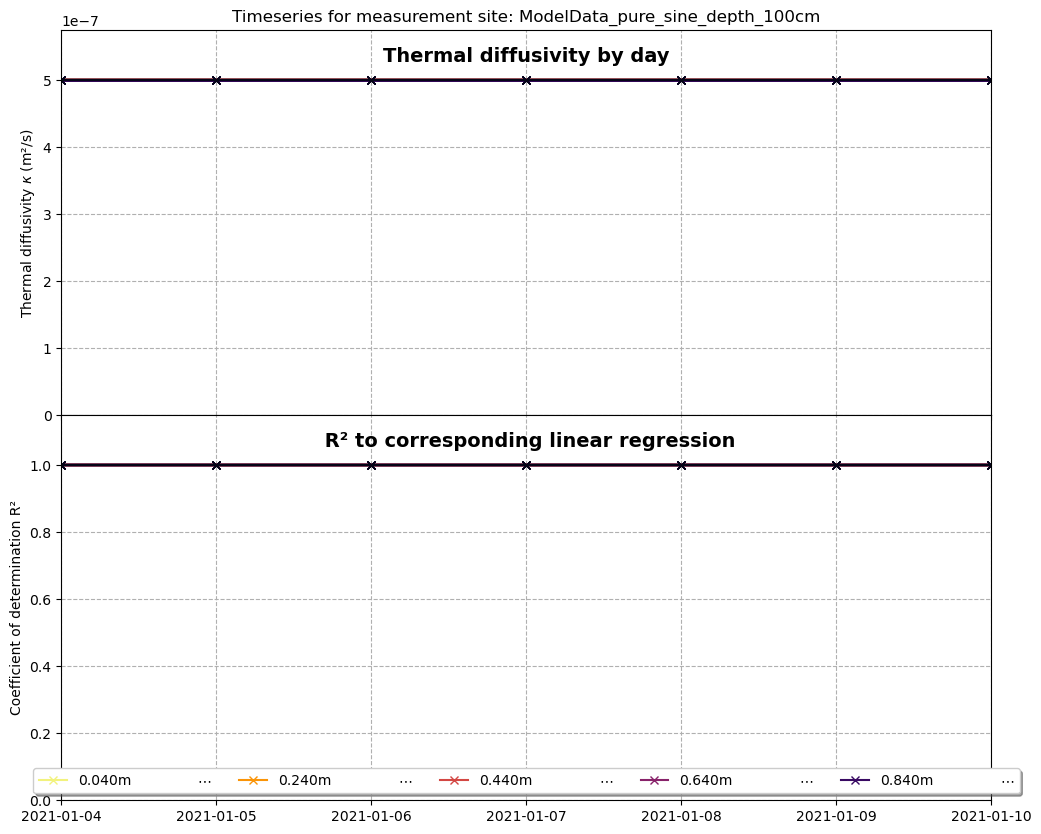

In [11]:
sel_sampling_time = 0
plotfunction.kappa_values_timeseries(dates_list, data[:, :, sel_sampling_time], 
                                     r_squared[:, :, sel_sampling_time], 
                                     depth, site, sel_average, save_figure)

In [12]:
print('Select value between 0 and ' + str(len(depth[1:-1])-1) + ' to select from depths:')
print(depth[1:-1])


Select value between 0 and 47 to select from depths:
['T_0.040m', 'T_0.060m', 'T_0.080m', 'T_0.100m', 'T_0.120m', 'T_0.140m', 'T_0.160m', 'T_0.180m', 'T_0.200m', 'T_0.220m', 'T_0.240m', 'T_0.260m', 'T_0.280m', 'T_0.300m', 'T_0.320m', 'T_0.340m', 'T_0.360m', 'T_0.380m', 'T_0.400m', 'T_0.420m', 'T_0.440m', 'T_0.460m', 'T_0.480m', 'T_0.500m', 'T_0.520m', 'T_0.540m', 'T_0.560m', 'T_0.580m', 'T_0.600m', 'T_0.620m', 'T_0.640m', 'T_0.660m', 'T_0.680m', 'T_0.700m', 'T_0.720m', 'T_0.740m', 'T_0.760m', 'T_0.780m', 'T_0.800m', 'T_0.820m', 'T_0.840m', 'T_0.860m', 'T_0.880m', 'T_0.900m', 'T_0.920m', 'T_0.940m', 'T_0.960m', 'T_0.980m']


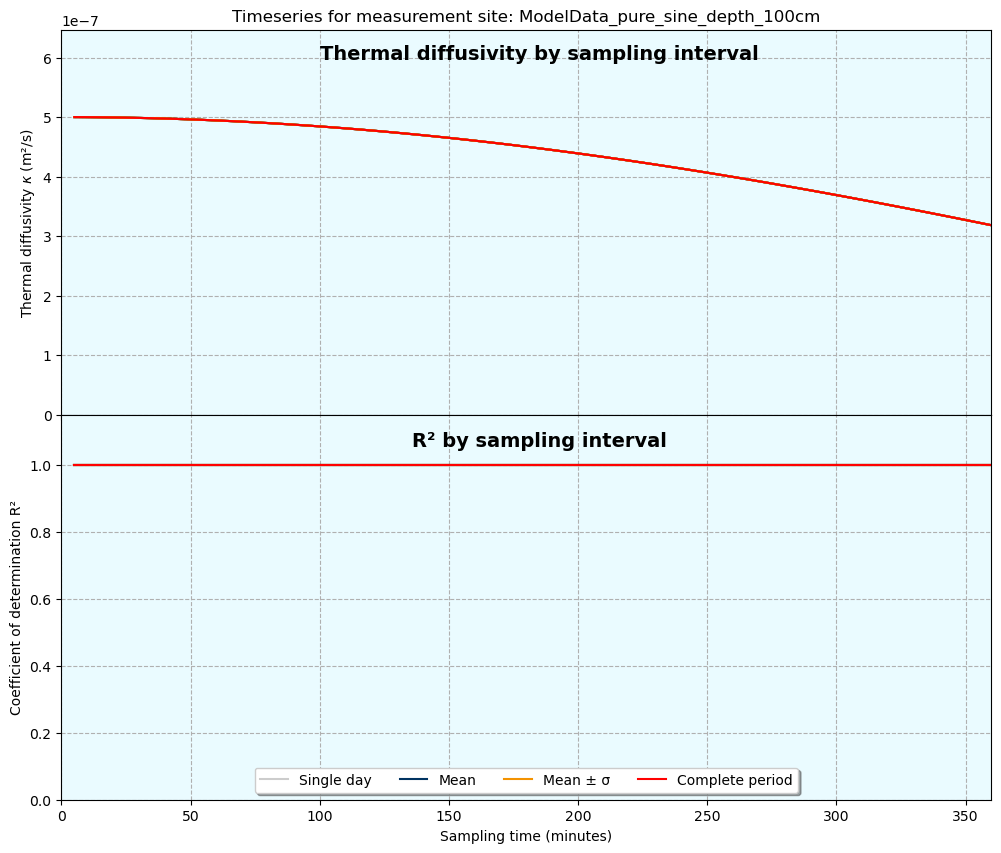

In [15]:
sel_depth = 0
plotfunction.resampling_time(data, data_period, r_squared, r_squared_period, steps_list, site, sel_depth,
                     sel_average, save_figure)